# Terminator

Procederé a aplicar todo lo que no aprendí este semestre según mis calificaciones 

In [3]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score, log_loss,get_scorer_names
import pandas as pd
import numpy as np
from sklearn import preprocessing as ps
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from scipy.optimize import minimize

In [4]:
d2=pd.read_csv("Data_set_200_280.csv")

In [5]:
d2

,Estado,Sumatoria,Mediana,Varianza
0,Healthy,5.556148e-07,4.686493e-10,0.000008
1,Healthy,6.529095e-07,2.819616e-10,0.000009
2,Healthy,6.096350e-07,2.985569e-10,0.000009
3,Healthy,5.567451e-07,2.556868e-10,0.000008
4,Healthy,5.016411e-07,3.071286e-10,0.000007
...,...,...,...,...
4914,Wheezes,1.017147e-05,1.164674e-08,0.000136
4915,Wheezes,9.649835e-06,8.796041e-09,0.000129
4916,Wheezes,1.124116e-06,7.448796e-10,0.000015
4917,Wheezes,9.903341e-07,4.516410e-10,0.000013


Inicialmente se hace un encoder para convertir las variables cualitativas en cuantitativas en este caso solo afectando la columna de estados

In [6]:
encoder = ps.LabelEncoder()
d2["Estado"]=encoder.fit_transform(d2["Estado"])
print(d2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4919 entries, 0 to 4918
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Estado     4919 non-null   int32  
 1   Sumatoria  4919 non-null   float64
 2   Mediana    4919 non-null   float64
 3   Varianza   4919 non-null   float64
dtypes: float64(3), int32(1)
memory usage: 134.6 KB
None


En este caso Sano:1 crepitante:0 y silibante:2

Normalizaremos los valores de cada columna dividiéndolos por el valor máximo para tener valores entre 0 y 1 en cada columna

In [7]:
for i in d2.columns.values[1:]:
    d2[i]=d2[i]/np.max(d2[i])

In [8]:
d2

,Estado,Sumatoria,Mediana,Varianza
0,1,0.000354,0.000049,0.000325
1,1,0.000416,0.000029,0.000369
2,1,0.000388,0.000031,0.000362
3,1,0.000354,0.000027,0.000315
4,1,0.000319,0.000032,0.000276
...,...,...,...,...
4914,2,0.006475,0.001218,0.005667
4915,2,0.006143,0.000920,0.005367
4916,2,0.000716,0.000078,0.000624
4917,2,0.000630,0.000047,0.000523


Ahora revisemos la correlación con nuestro target de predicción que seria el estado

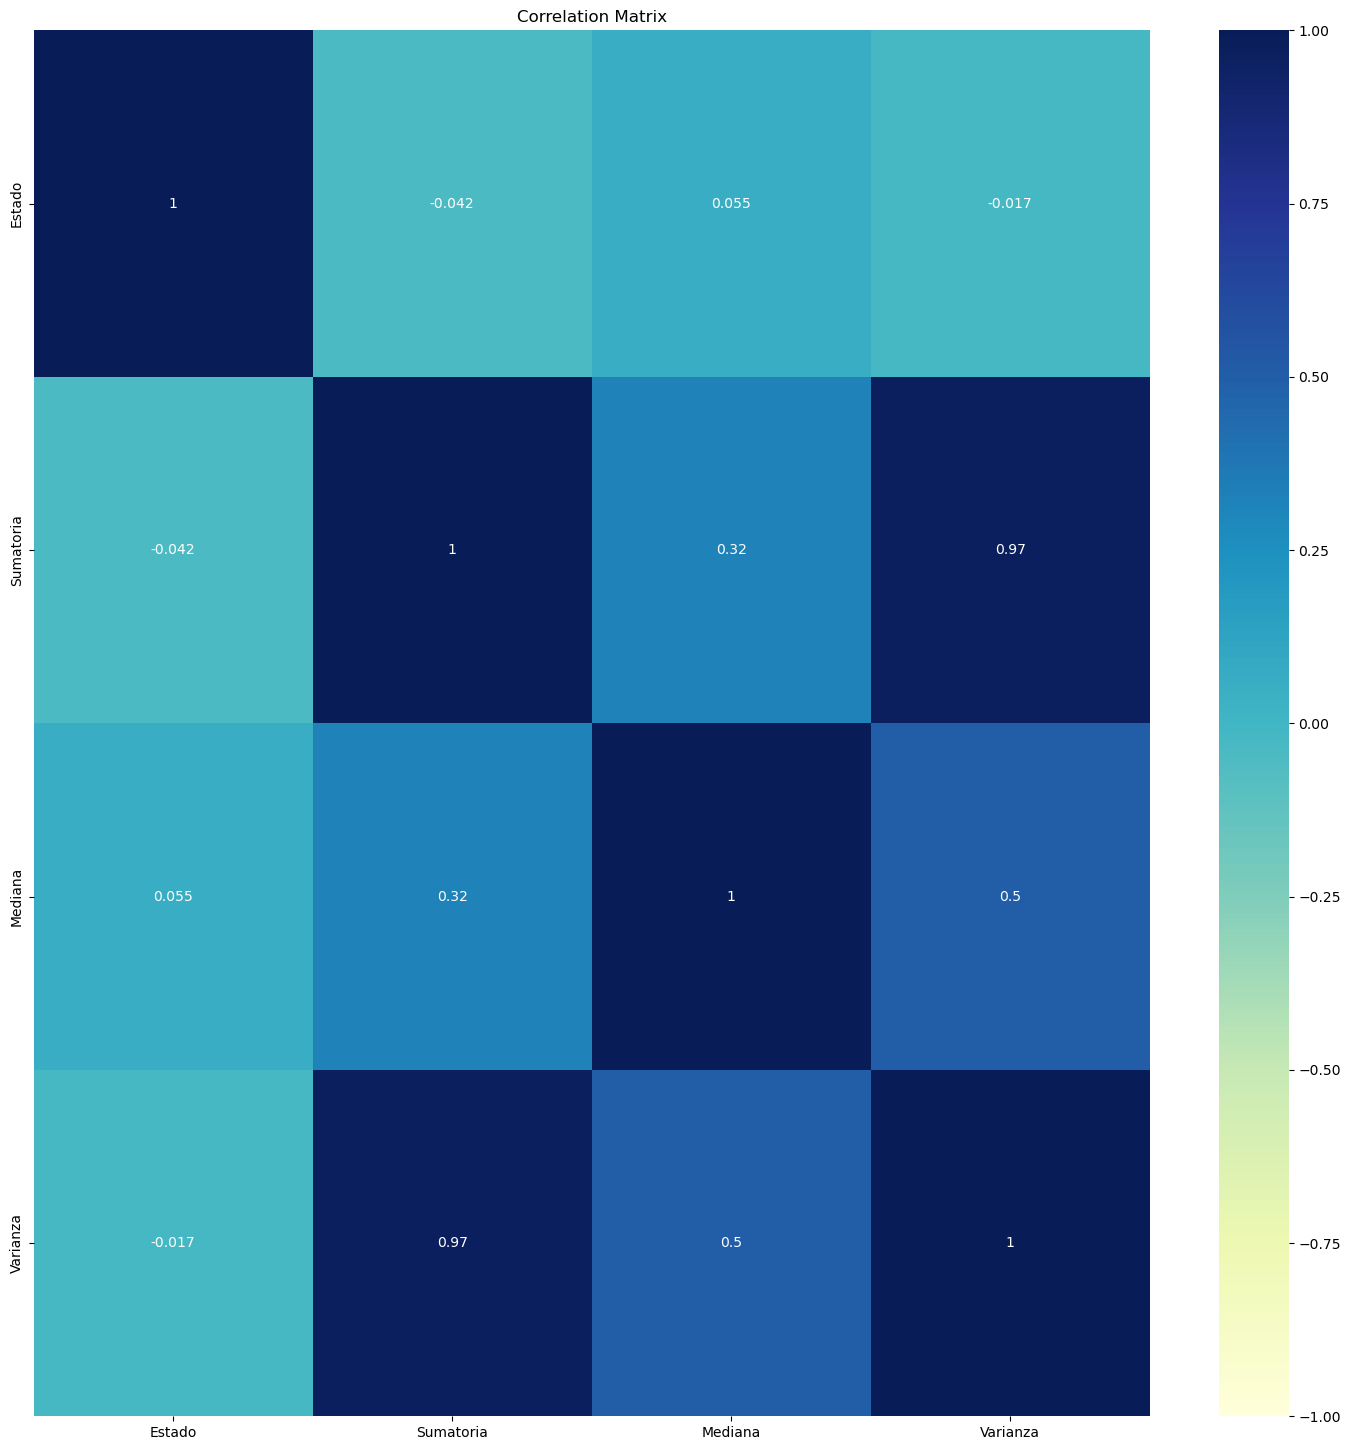

In [9]:
corr_matrix = d2.corr()
plt.figure(figsize=(18,18))
sns.heatmap(corr_matrix, annot = True, vmin = -1, vmax = 1, cmap = "YlGnBu").set_title('Correlation Matrix')
plt.show()

In [10]:
target_corr_df = pd.DataFrame(corr_matrix["Estado"].sort_values(ascending=False))
target_corr_df 

,Estado
Estado,1.000000
Mediana,0.054825
Varianza,-0.016609
Sumatoria,-0.042180


En este caso podemos observar que el estado va relacionado mayormente con la mediana que en el caso de la varianza o la suma, con esto en mente priorizaremos este parámetro para la generación de las redes neuronales

# 1. Ciclos normales y ciclos crepitantes

## Entrenamiento

In [28]:
con=(d2.Estado.values==1)|(d2.Estado.values==0)
x=d2.drop(["Estado"],axis=1)[con]
y=d2.Estado.values[con]
test_size = 0.3
val_size  = test_size/(1-test_size) # Elementos de validación


print (x.shape, y.shape)
print ("test size %.2f"%test_size)
print ("val size is %.2f (relative to %.2f) "%(val_size, 1-test_size))

Xtv, Xts, ytv, yts = train_test_split(x, y, test_size=test_size)

print (Xtv.shape, Xts.shape)

(4264, 3) (4264,)
test size 0.30
val size is 0.43 (relative to 0.70) 
(2984, 3) (1280, 3)


In [29]:
from itertools import product
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    fig=plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [30]:
def tuple_generator(start, end):
        for i in range(start, end + 1):
            yield (i, i, i)

In [31]:
def optimizador(Xtv,ytv,Xts,yts,start=1,end=20):
    best=0
    best_a=0
    def tuple_generator1(start, end):
        for i in range(start, end + 1):
            yield (i, i, i)
    iter=list(tuple_generator1(start,end))
    for n in iter:
        mlp_relu = MLPClassifier(hidden_layer_sizes=n, activation='relu', solver='adam', max_iter=10000) 
        mlp_identity = MLPClassifier(hidden_layer_sizes=n, activation='identity', solver='adam', max_iter=10000) 
        mlp_tanh = MLPClassifier(hidden_layer_sizes=n, activation='tanh', solver='adam', max_iter=10000)
        mlp_logic=MLPClassifier(hidden_layer_sizes=n, activation='logistic', solver='adam', max_iter=10000)
        a=[mlp_relu,mlp_identity,mlp_tanh,mlp_logic]
        for n in a:
            n.fit(Xtv,ytv)
            acc=accuracy_score(yts,n.predict(Xts))
            if best_a<acc:
                best_a=acc
                best=n
    return best
        

In [32]:
def metrics(a,Xtv,ytv,Xts,yts,target_names):
    a.fit(Xtv,ytv)
    predict_train = a.predict(Xtv)
    predict_test = a.predict(Xts)
    print("Train ",a.activation)
    print("------------")
    print(classification_report(ytv,predict_train))
    mc_train = confusion_matrix(ytv,predict_train)
    plot_confusion_matrix(mc_train, classes=target_names,title='Confusion matrix train '+a.activation)
    print("------------")
    print("Test ",a.activation)
    print(classification_report(yts,predict_test))
    mc_train = confusion_matrix(yts,predict_test)
    plot_confusion_matrix(mc_train, classes=target_names,title='Confusion matrix test '+a.activation)

In [33]:
def tuple_generator(start, end):
    return list(itertools.product(range(start, end+ 1), repeat=3))

In [34]:
def me_da_pereza(i,Xtv,ytv,Xts,yts,target_names):
    for a in i:
        metrics(a,Xtv,ytv,Xts,yts,target_names)

## Funciones de perdida para optimización

- Para problemas binarios usar Binary Cross-Entropy, para multicategoricos usar Categorical Cross-Entropy (CCE)

En este caso vamos a probar con varias redes neuronales, cambiaremos la activación para cambiar la arquitectura lo mismo que el solucionador de ser necesario, esto cambiara la forma del sigmoide, en el proceso se ira permutando los valores hasta encontrar un modelo más adecuado para la predicción 

## Resultados

## Lo que si se pidió

Train  relu
------------
              precision    recall  f1-score   support

           0       0.58      0.31      0.40      1135
           1       0.67      0.87      0.76      1849

    accuracy                           0.65      2984
   macro avg       0.63      0.59      0.58      2984
weighted avg       0.64      0.65      0.62      2984

Confusion matrix, without normalization
[[ 350  785]
 [ 249 1600]]
------------
Test  relu
              precision    recall  f1-score   support

           0       0.56      0.28      0.37       496
           1       0.65      0.86      0.74       784

    accuracy                           0.64      1280
   macro avg       0.61      0.57      0.56      1280
weighted avg       0.62      0.64      0.60      1280

Confusion matrix, without normalization
[[138 358]
 [107 677]]
Train  identity
------------
              precision    recall  f1-score   support

           0       0.66      0.05      0.10      1135
           1       0.63      

c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\

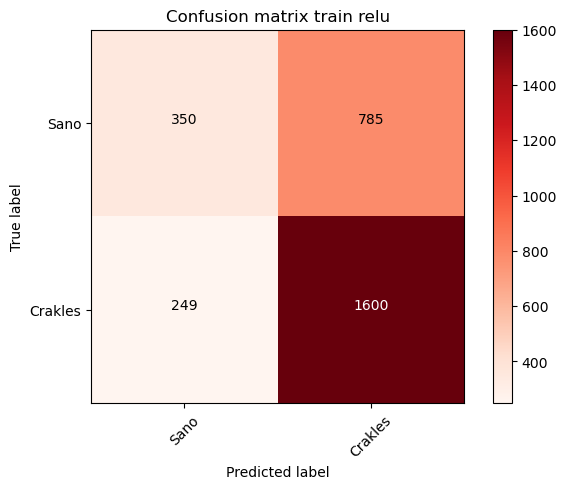

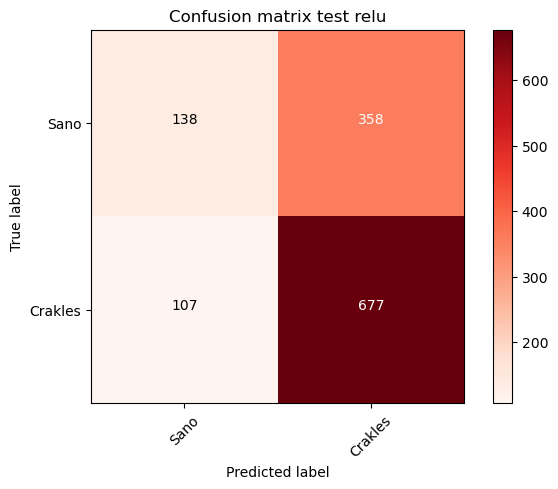

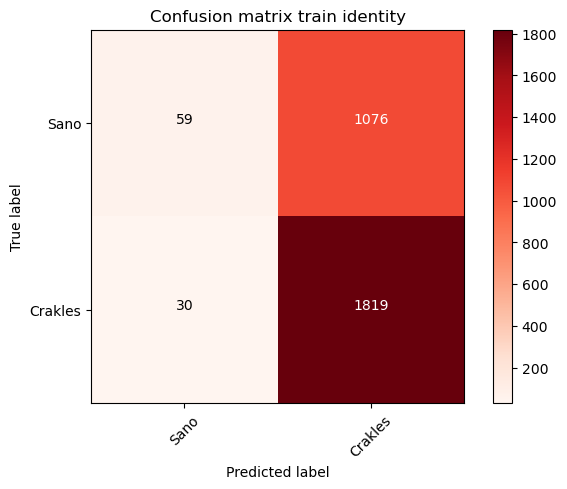

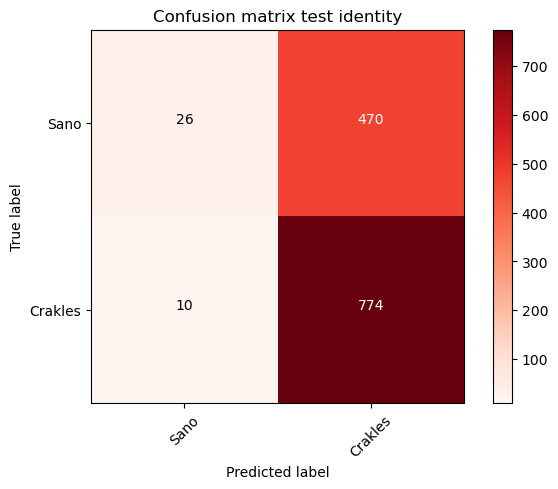

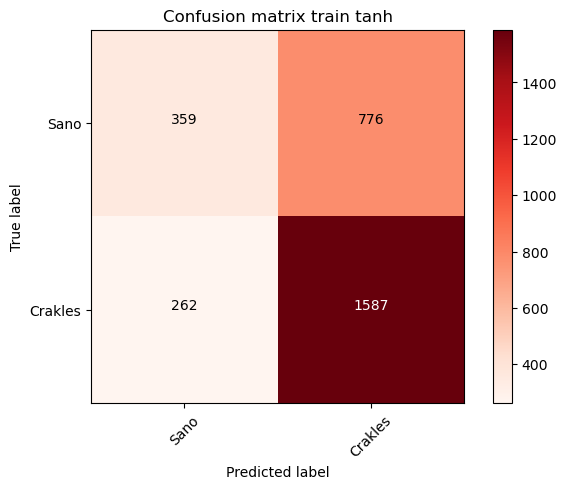

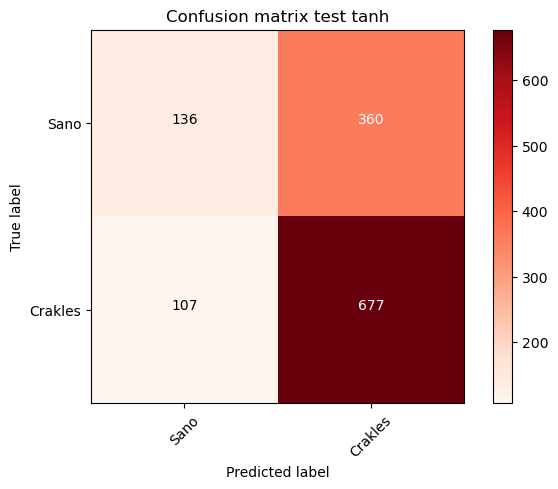

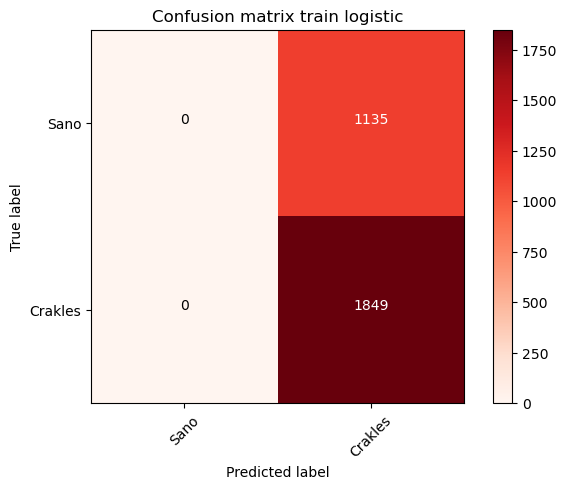

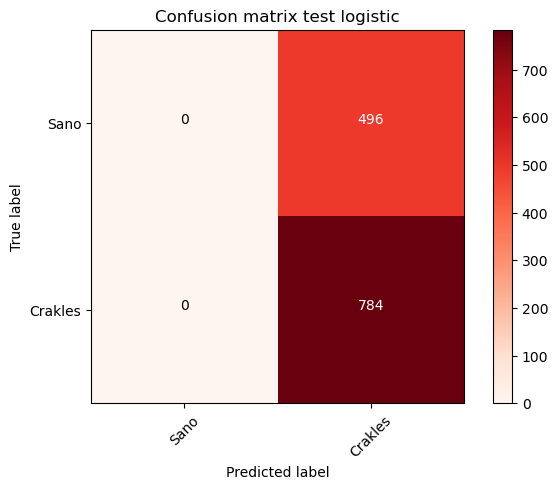

In [35]:
mlp_relu = MLPClassifier(hidden_layer_sizes=(20,20,20), activation='relu', solver='adam', max_iter=10000) 
mlp_identity = MLPClassifier(hidden_layer_sizes=(20,20,20), activation='identity', solver='adam', max_iter=10000) 
mlp_tanh = MLPClassifier(hidden_layer_sizes=(20,20,20), activation='tanh', solver='adam', max_iter=10000)
mlp_logic=MLPClassifier(hidden_layer_sizes=(20,20,20), activation='logistic', solver='adam', max_iter=10000)
a=[mlp_relu,mlp_identity,mlp_tanh,mlp_logic]
me_da_pereza(a,Xtv,ytv,Xts,yts,['Sano','Crakles'])

## Lo que no se pidió

Train  relu
------------
              precision    recall  f1-score   support

           0       0.55      0.46      0.50      1135
           1       0.70      0.76      0.73      1849

    accuracy                           0.65      2984
   macro avg       0.62      0.61      0.61      2984
weighted avg       0.64      0.65      0.64      2984

Confusion matrix, without normalization
[[ 524  611]
 [ 436 1413]]
------------
Test  relu
              precision    recall  f1-score   support

           0       0.55      0.47      0.51       496
           1       0.69      0.76      0.72       784

    accuracy                           0.65      1280
   macro avg       0.62      0.62      0.62      1280
weighted avg       0.64      0.65      0.64      1280

Confusion matrix, without normalization
[[235 261]
 [190 594]]
MLPClassifier(hidden_layer_sizes=(13, 13, 13), max_iter=10000)
Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END ....................hidden_layer_

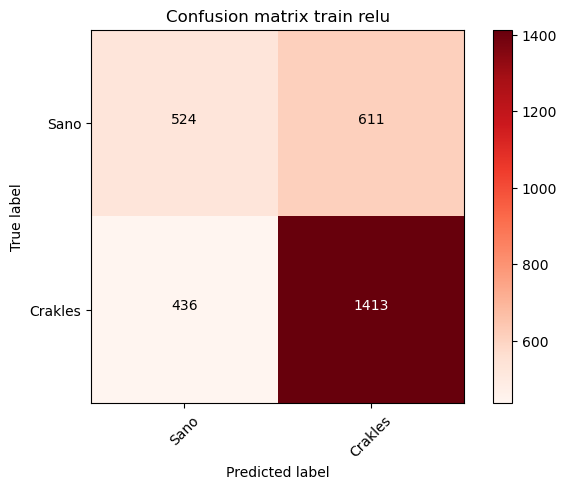

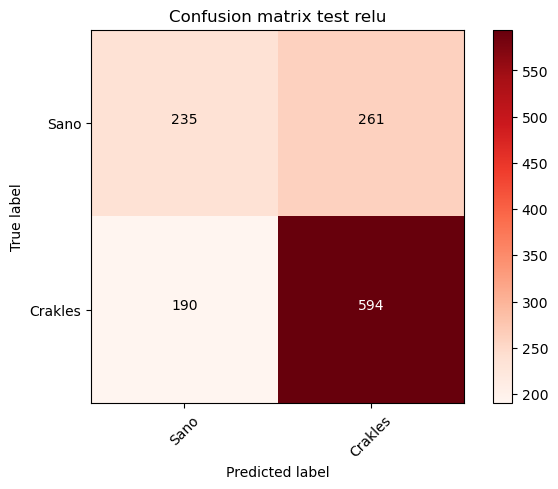

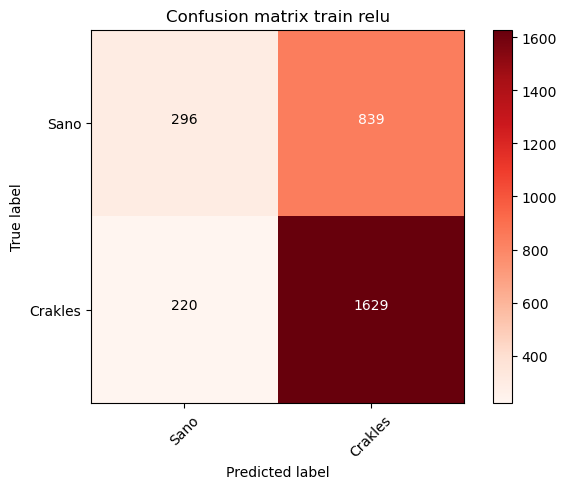

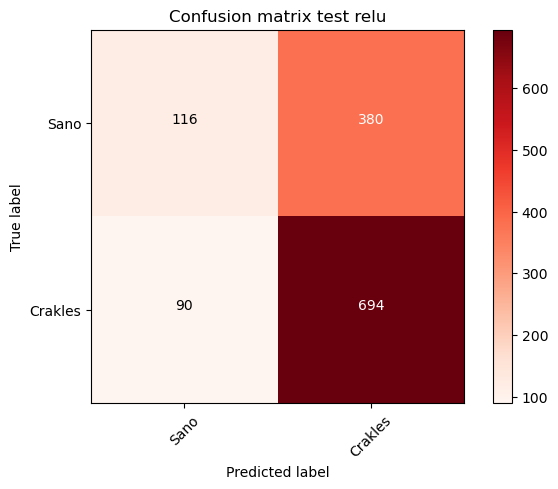

In [36]:
#Se busca el mejor sigmoide con los mejores macro parametros en este caso con la función de acurracy
best=optimizador(Xtv,ytv,Xts,yts,start=1,end=20)
metrics(best,Xtv,ytv,Xts,yts,['Sano','Crakles'])
print(best)
#Se busca una pequeña optimización con respecto a esos macroparametros, en este caso usando como puntuación la funcion f1
sem,_,_=best.hidden_layer_sizes
if sem>2:
    start=sem-2
    end=sem
else:
    start=sem
    end=sem+2
it=tuple_generator(start,end)
param_grid = {'hidden_layer_sizes': it}
grid_search = GridSearchCV(best, param_grid, cv=5,verbose=2,scoring='f1')
grid_search.fit(Xtv, ytv)
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best Parameters:", best_params)
print("Best Score:", best_score)
#Se crea la mejor red neuronal posible con los parametros anteriores
the_bestest=MLPClassifier(hidden_layer_sizes=best_params["hidden_layer_sizes"], activation=best.activation, solver='adam', max_iter=10000) 
metrics(the_bestest,Xtv,ytv,Xts,yts,['Sano','Crakles'])

Pero que parámetros son mejores:

# 2. Ciclos normales y ciclos silbantes

## Lo que pide el trabajo:

(3288, 3) (3288,)
test size 0.30
val size is 0.43 (relative to 0.70) 
(2301, 3) (987, 3)
Train  relu
------------
              precision    recall  f1-score   support

           1       0.80      1.00      0.89      1850
           2       0.00      0.00      0.00       451

    accuracy                           0.80      2301
   macro avg       0.40      0.50      0.45      2301
weighted avg       0.65      0.80      0.72      2301

Confusion matrix, without normalization
[[1850    0]
 [ 451    0]]


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\

------------
Test  relu
              precision    recall  f1-score   support

           1       0.79      1.00      0.88       783
           2       0.00      0.00      0.00       204

    accuracy                           0.79       987
   macro avg       0.40      0.50      0.44       987
weighted avg       0.63      0.79      0.70       987

Confusion matrix, without normalization
[[783   0]
 [204   0]]
Train  identity
------------
              precision    recall  f1-score   support

           1       0.80      1.00      0.89      1850
           2       0.00      0.00      0.00       451

    accuracy                           0.80      2301
   macro avg       0.40      0.50      0.45      2301
weighted avg       0.65      0.80      0.72      2301

Confusion matrix, without normalization
[[1850    0]
 [ 451    0]]
------------
Test  identity
              precision    recall  f1-score   support

           1       0.79      1.00      0.88       783
           2       0.00   

c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\

Train  tanh
------------
              precision    recall  f1-score   support

           1       0.80      1.00      0.89      1850
           2       0.00      0.00      0.00       451

    accuracy                           0.80      2301
   macro avg       0.40      0.50      0.45      2301
weighted avg       0.65      0.80      0.72      2301

Confusion matrix, without normalization
[[1850    0]
 [ 451    0]]
------------
Test  tanh
              precision    recall  f1-score   support

           1       0.79      1.00      0.88       783
           2       0.00      0.00      0.00       204

    accuracy                           0.79       987
   macro avg       0.40      0.50      0.44       987
weighted avg       0.63      0.79      0.70       987

Confusion matrix, without normalization
[[783   0]
 [204   0]]


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\

Train  logistic
------------
              precision    recall  f1-score   support

           1       0.80      1.00      0.89      1850
           2       0.00      0.00      0.00       451

    accuracy                           0.80      2301
   macro avg       0.40      0.50      0.45      2301
weighted avg       0.65      0.80      0.72      2301

Confusion matrix, without normalization
[[1850    0]
 [ 451    0]]
------------
Test  logistic
              precision    recall  f1-score   support

           1       0.79      1.00      0.88       783
           2       0.00      0.00      0.00       204

    accuracy                           0.79       987
   macro avg       0.40      0.50      0.44       987
weighted avg       0.63      0.79      0.70       987

Confusion matrix, without normalization
[[783   0]
 [204   0]]


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


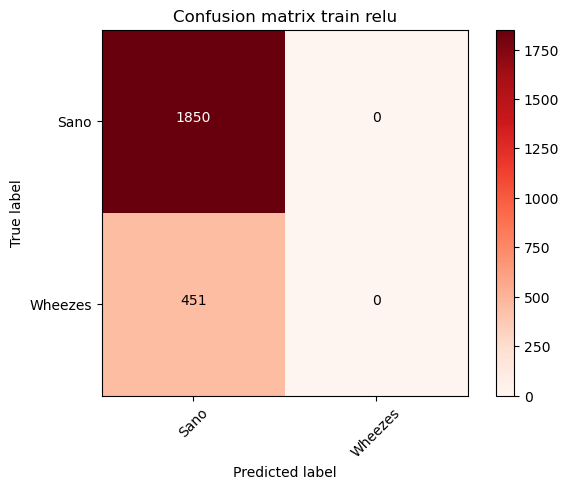

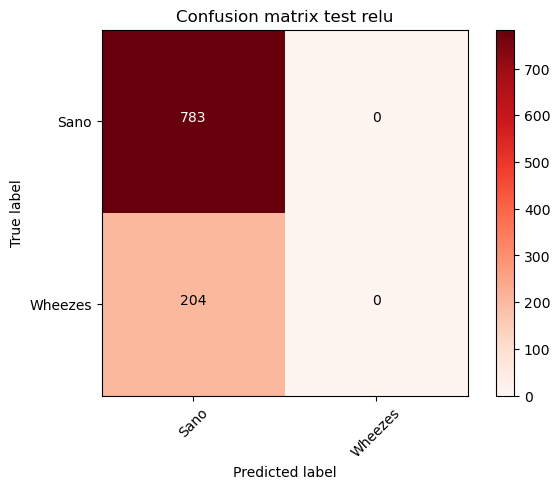

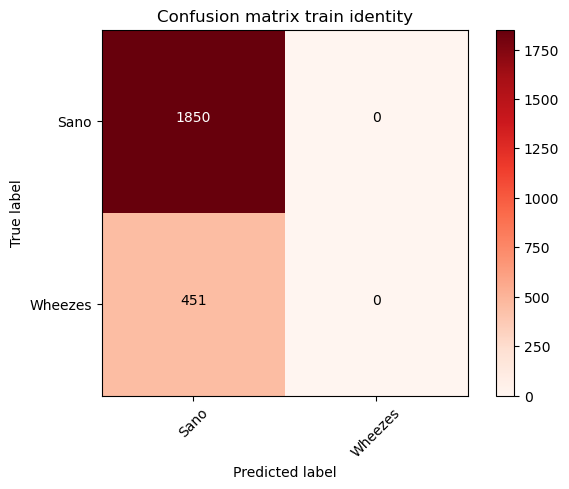

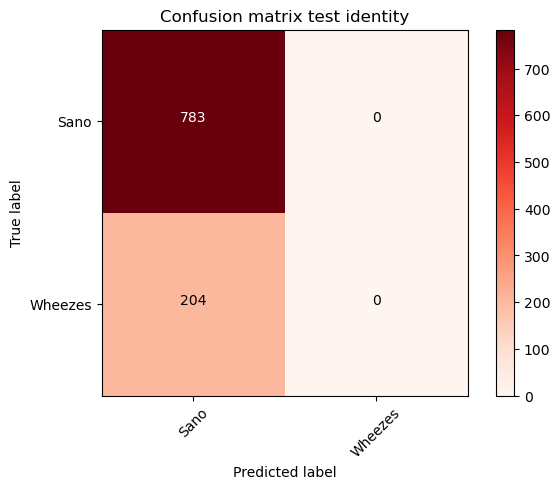

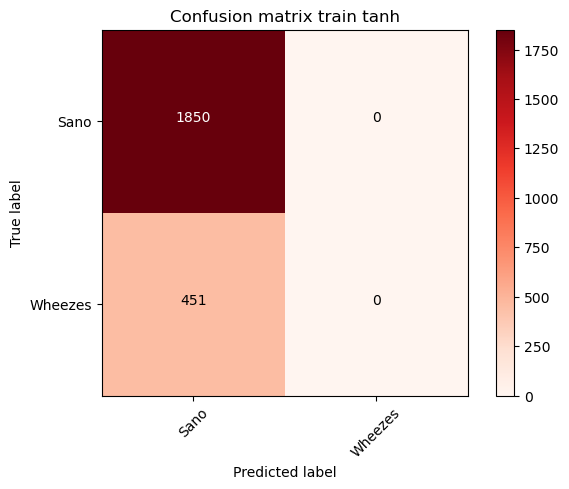

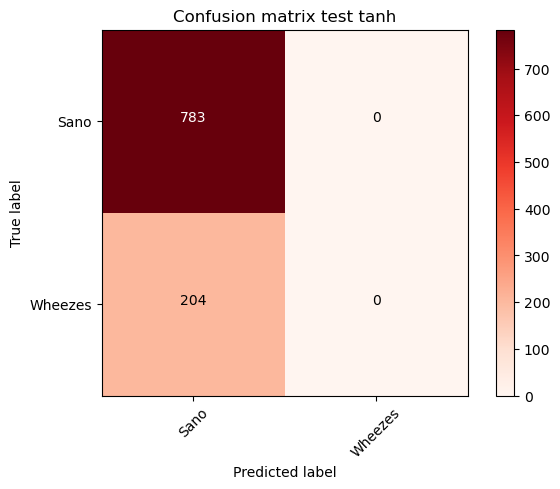

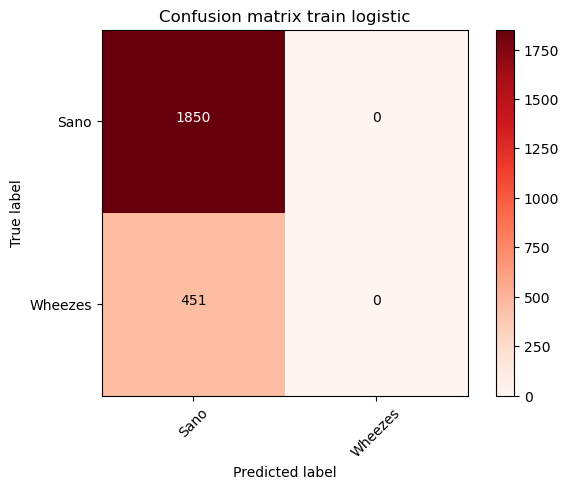

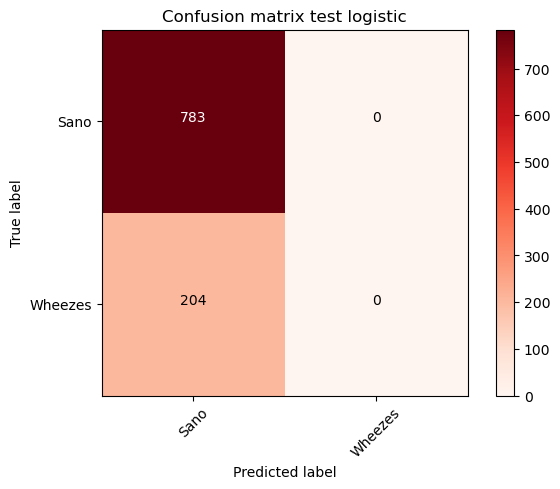

In [37]:
con=(d2.Estado.values==1)|(d2.Estado.values==2)
x=d2.drop(["Estado"],axis=1)[con]
y=d2.Estado.values[con]
test_size = 0.3
val_size  = test_size/(1-test_size) # Elementos de validación


print (x.shape, y.shape)
print ("test size %.2f"%test_size)
print ("val size is %.2f (relative to %.2f) "%(val_size, 1-test_size))

Xtv, Xts, ytv, yts = train_test_split(x, y, test_size=test_size)

print (Xtv.shape, Xts.shape)
mlp_relu = MLPClassifier(hidden_layer_sizes=(20,20,20), activation='relu', solver='adam', max_iter=10000) 
mlp_identity = MLPClassifier(hidden_layer_sizes=(20,20,20), activation='identity', solver='adam', max_iter=10000) 
mlp_tanh = MLPClassifier(hidden_layer_sizes=(20,20,20), activation='tanh', solver='adam', max_iter=10000)
mlp_logic=MLPClassifier(hidden_layer_sizes=(20,20,20), activation='logistic', solver='adam', max_iter=10000)
a=[mlp_relu,mlp_identity,mlp_tanh,mlp_logic]
me_da_pereza(a,Xtv,ytv,Xts,yts,['Sano','Wheezes'])

## La optimización porque no voy a perder lo que estudie en IA

Train  relu
------------
              precision    recall  f1-score   support

           1       0.80      1.00      0.89      1850
           2       0.00      0.00      0.00       451

    accuracy                           0.80      2301
   macro avg       0.40      0.50      0.45      2301
weighted avg       0.65      0.80      0.72      2301

Confusion matrix, without normalization
[[1850    0]
 [ 451    0]]
------------
Test  relu
              precision    recall  f1-score   support

           1       0.79      1.00      0.88       783
           2       0.00      0.00      0.00       204

    accuracy                           0.79       987
   macro avg       0.40      0.50      0.44       987
weighted avg       0.63      0.79      0.70       987

Confusion matrix, without normalization
[[783   0]
 [204   0]]
MLPClassifier(hidden_layer_sizes=(1, 1, 1), max_iter=10000)
Fitting 5 folds for each of 27 candidates, totalling 135 fits


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\

[CV] END .......................hidden_layer_sizes=(1, 1, 1); total time=   0.8s
[CV] END .......................hidden_layer_sizes=(1, 1, 1); total time=   0.1s
[CV] END .......................hidden_layer_sizes=(1, 1, 1); total time=   0.0s
[CV] END .......................hidden_layer_sizes=(1, 1, 1); total time=   0.7s
[CV] END .......................hidden_layer_sizes=(1, 1, 1); total time=   0.0s
[CV] END .......................hidden_layer_sizes=(1, 1, 2); total time=   0.3s
[CV] END .......................hidden_layer_sizes=(1, 1, 2); total time=   0.2s
[CV] END .......................hidden_layer_sizes=(1, 1, 2); total time=   0.2s
[CV] END .......................hidden_layer_sizes=(1, 1, 2); total time=   0.1s
[CV] END .......................hidden_layer_sizes=(1, 1, 2); total time=   0.0s
[CV] END .......................hidden_layer_sizes=(1, 1, 3); total time=   0.0s
[CV] END .......................hidden_layer_sizes=(1, 1, 3); total time=   0.1s
[CV] END ...................

c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\

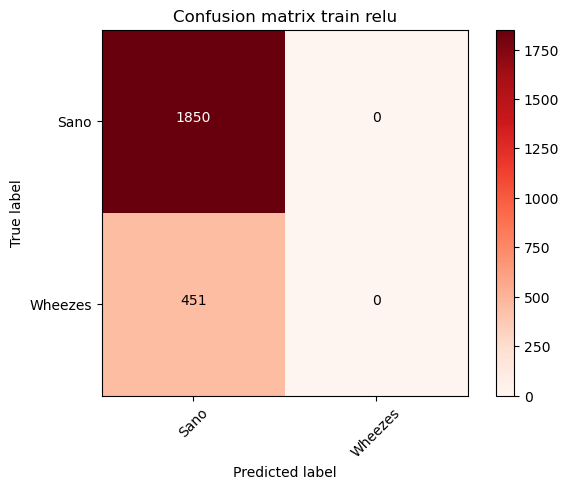

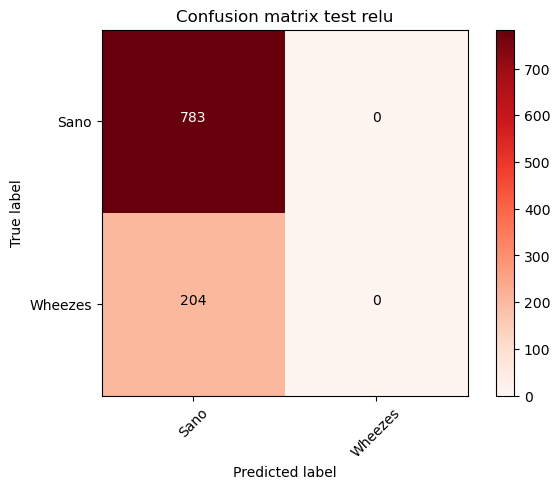

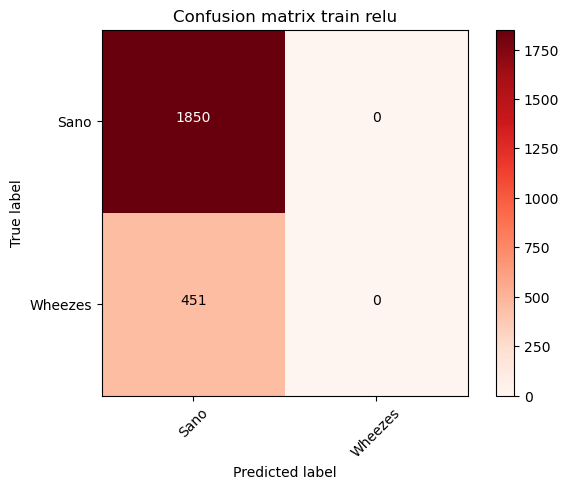

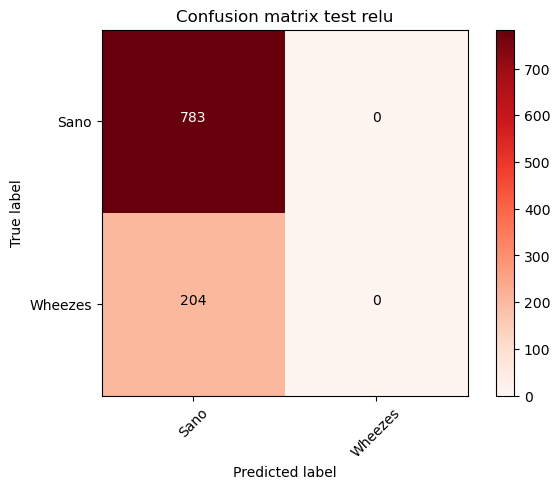

In [38]:
#Se busca el mejor sigmoide con los mejores macro parametros en este caso con la función de acurracy
best=optimizador(Xtv,ytv,Xts,yts,start=1,end=20)
metrics(best,Xtv,ytv,Xts,yts,['Sano','Wheezes'])
print(best)
#Se busca una pequeña optimización con respecto a esos macroparametros, en este caso usando como puntuación la funcion f1
sem,_,_=best.hidden_layer_sizes
if sem>2:
    start=sem-2
    end=sem
else:
    start=sem
    end=sem+2
it=tuple_generator(start,end)
param_grid = {'hidden_layer_sizes': it}
grid_search = GridSearchCV(best, param_grid, cv=5,verbose=2,scoring='f1')
grid_search.fit(Xtv, ytv)
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best Parameters:", best_params)
print("Best Score:", best_score)
#Se crea la mejor red neuronal posible con los parametros anteriores
the_bestest=MLPClassifier(hidden_layer_sizes=best_params["hidden_layer_sizes"], activation=best.activation, solver='adam', max_iter=10000) 
metrics(the_bestest,Xtv,ytv,Xts,yts,['Sano','Wheezes'])

## 3. Silibantes y crepitantes

## Lo que si 

(2286, 3) (2286,)
test size 0.30
val size is 0.43 (relative to 0.70) 
(1600, 3) (686, 3)
Train  relu
------------
              precision    recall  f1-score   support

           0       0.72      1.00      0.84      1148
           1       0.00      0.00      0.00       452

    accuracy                           0.72      1600
   macro avg       0.36      0.50      0.42      1600
weighted avg       0.51      0.72      0.60      1600

Confusion matrix, without normalization
[[1148    0]
 [ 452    0]]
------------
Test  relu
              precision    recall  f1-score   support

           0       0.70      1.00      0.83       483
           1       0.00      0.00      0.00       203

    accuracy                           0.70       686
   macro avg       0.35      0.50      0.41       686
weighted avg       0.50      0.70      0.58       686

Confusion matrix, without normalization
[[483   0]
 [203   0]]


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\

Train  identity
------------
              precision    recall  f1-score   support

           0       0.72      1.00      0.84      1148
           1       0.77      0.02      0.04       452

    accuracy                           0.72      1600
   macro avg       0.75      0.51      0.44      1600
weighted avg       0.73      0.72      0.61      1600

Confusion matrix, without normalization
[[1145    3]
 [ 442   10]]
------------
Test  identity
              precision    recall  f1-score   support

           0       0.70      1.00      0.83       483
           1       0.33      0.00      0.01       203

    accuracy                           0.70       686
   macro avg       0.52      0.50      0.42       686
weighted avg       0.59      0.70      0.58       686

Confusion matrix, without normalization
[[481   2]
 [202   1]]
Train  tanh
------------
              precision    recall  f1-score   support

           0       0.72      1.00      0.84      1148
           1       0.72  

c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.72      1.00      0.84      1148
           1       0.00      0.00      0.00       452

    accuracy                           0.72      1600
   macro avg       0.36      0.50      0.42      1600
weighted avg       0.51      0.72      0.60      1600

Confusion matrix, without normalization
[[1148    0]
 [ 452    0]]
------------
Test  logistic
              precision    recall  f1-score   support

           0       0.70      1.00      0.83       483
           1       0.00      0.00      0.00       203

    accuracy                           0.70       686
   macro avg       0.35      0.50      0.41       686
weighted avg       0.50      0.70      0.58       686

Confusion matrix, without normalization
[[483   0]
 [203   0]]


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


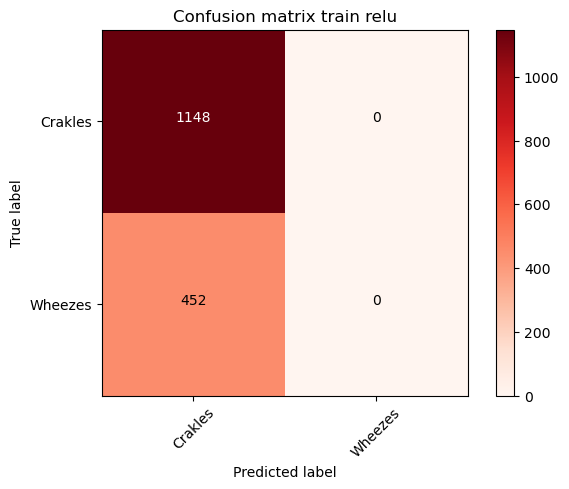

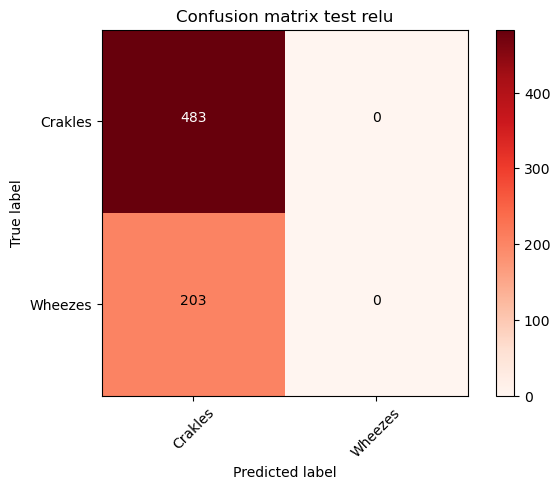

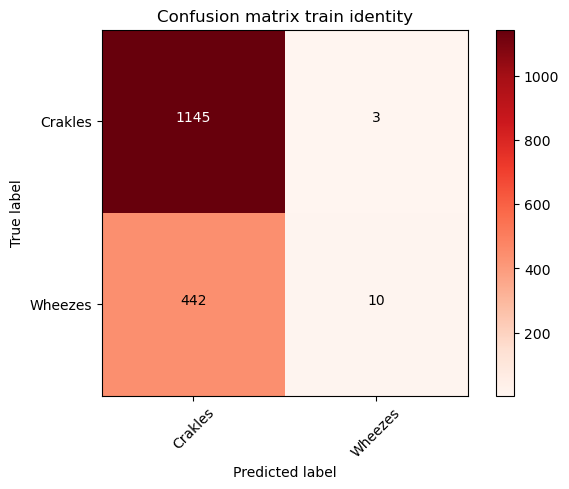

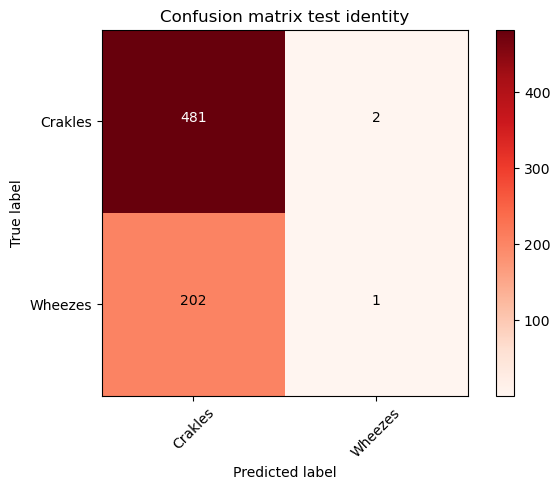

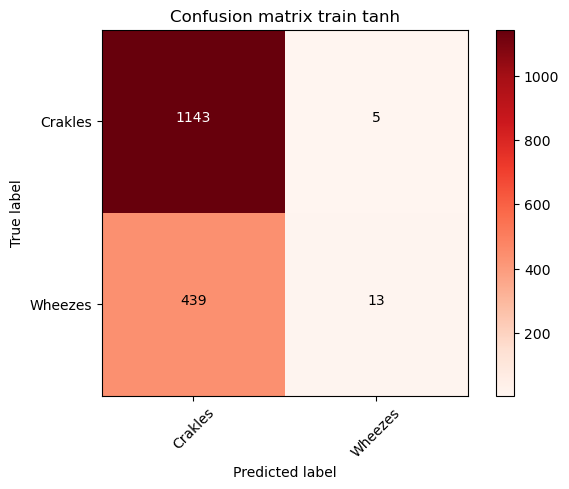

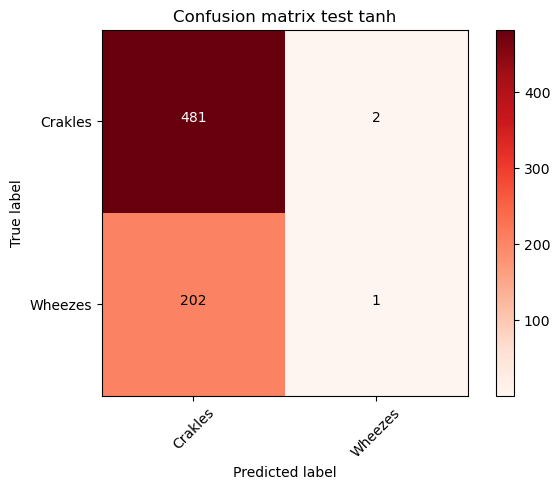

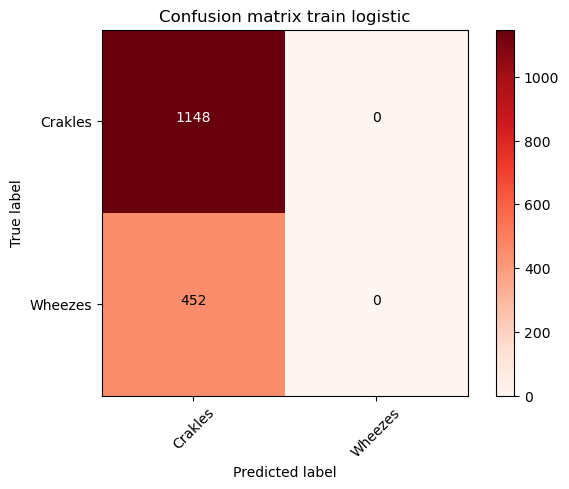

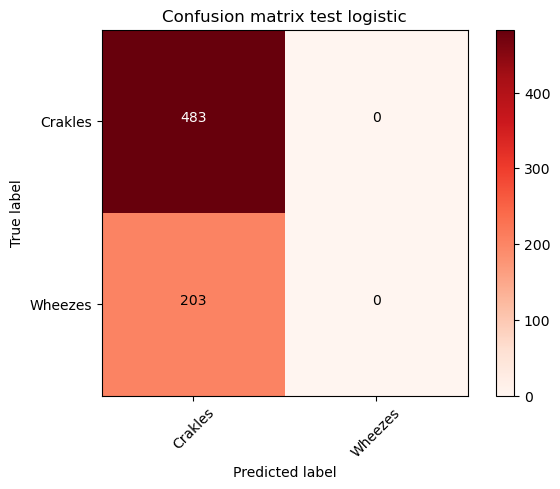

In [65]:
con=(d2.Estado.values==0)|(d2.Estado.values==2)
x=d2.drop(["Estado"],axis=1)[con]
y=d2.Estado.values[con]
np.putmask(y,y == 2,1)
test_size = 0.3
val_size  = test_size/(1-test_size) # Elementos de validación


print (x.shape, y.shape)
print ("test size %.2f"%test_size)
print ("val size is %.2f (relative to %.2f) "%(val_size, 1-test_size))

Xtv, Xts, ytv, yts = train_test_split(x, y, test_size=test_size)

print (Xtv.shape, Xts.shape)
mlp_relu = MLPClassifier(hidden_layer_sizes=(20,20,20), activation='relu', solver='adam', max_iter=10000) 
mlp_identity = MLPClassifier(hidden_layer_sizes=(20,20,20), activation='identity', solver='adam', max_iter=10000) 
mlp_tanh = MLPClassifier(hidden_layer_sizes=(20,20,20), activation='tanh', solver='adam', max_iter=10000)
mlp_logic=MLPClassifier(hidden_layer_sizes=(20,20,20), activation='logistic', solver='adam', max_iter=10000)
a=[mlp_relu,mlp_identity,mlp_tanh,mlp_logic]
me_da_pereza(a,Xtv,ytv,Xts,yts,['Crakles','Wheezes'])

## Lo que espero que nos den más nota:

Train  relu
------------
              precision    recall  f1-score   support

           0       0.73      0.99      0.84      1148
           1       0.63      0.05      0.10       452

    accuracy                           0.72      1600
   macro avg       0.68      0.52      0.47      1600
weighted avg       0.70      0.72      0.63      1600

Confusion matrix, without normalization
[[1134   14]
 [ 428   24]]
------------
Test  relu
              precision    recall  f1-score   support

           0       0.71      0.99      0.83       483
           1       0.56      0.02      0.05       203

    accuracy                           0.71       686
   macro avg       0.63      0.51      0.44       686
weighted avg       0.66      0.71      0.60       686

Confusion matrix, without normalization
[[479   4]
 [198   5]]
MLPClassifier(hidden_layer_sizes=(20, 20, 20), max_iter=10000)
Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END ....................hidden_layer_

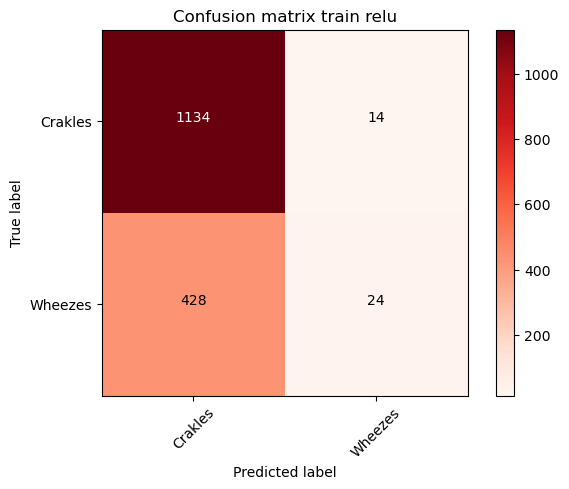

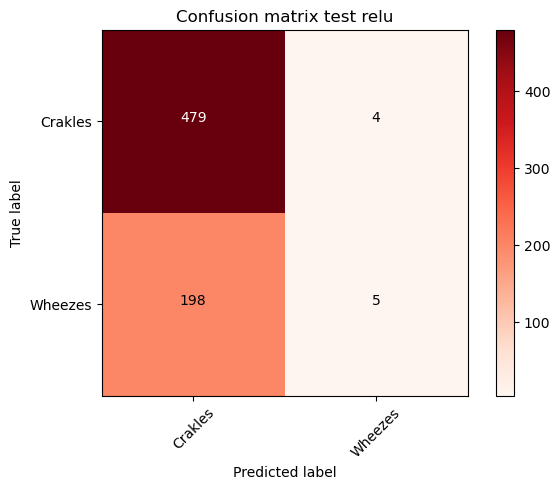

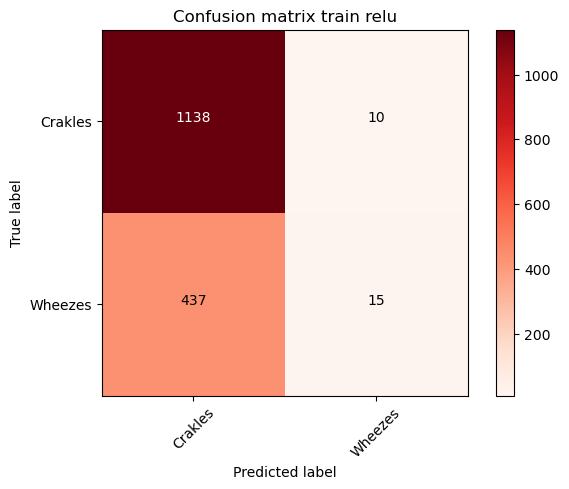

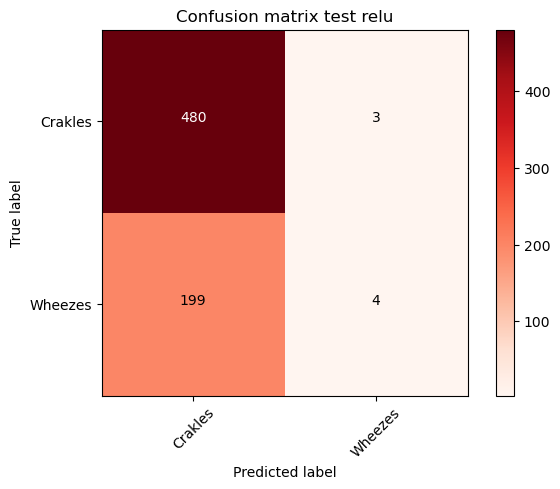

In [66]:
#Se busca el mejor sigmoide con los mejores macro parametros en este caso con la función de acurracy
best=optimizador(Xtv,ytv,Xts,yts,start=1,end=20)
metrics(best,Xtv,ytv,Xts,yts,['Crakles','Wheezes'])
print(best)
#Se busca una pequeña optimización con respecto a esos macroparametros, en este caso usando como puntuación la funcion f1
sem,_,_=best.hidden_layer_sizes
if sem>2:
    start=sem-2
    end=sem
else:
    start=sem
    end=sem+2
it=tuple_generator(start,end)
param_grid = {'hidden_layer_sizes': it}
grid_search = GridSearchCV(best, param_grid, cv=5,verbose=2,scoring='f1')
grid_search.fit(Xtv, ytv)
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best Parameters:", best_params)
print("Best Score:", best_score)
#Se crea la mejor red neuronal posible con los parametros anteriores
the_bestest=MLPClassifier(hidden_layer_sizes=best_params["hidden_layer_sizes"], activation=best.activation, solver='adam', max_iter=10000) 
metrics(the_bestest,Xtv,ytv,Xts,yts,['Crakles','Wheezes'])

# 4. Normales, silibantes y crepitantes

## Franklin perdón si llegas hasta aquí

(4919, 3) (4919,)
test size 0.30
val size is 0.43 (relative to 0.70) 
(3443, 3) (1476, 3)
Train  relu
------------
              precision    recall  f1-score   support

           0       0.51      0.26      0.35      1140
           1       0.57      0.88      0.69      1842
           2       0.00      0.00      0.00       461

    accuracy                           0.56      3443
   macro avg       0.36      0.38      0.35      3443
weighted avg       0.47      0.56      0.48      3443

Confusion matrix, without normalization
[[ 302  838    0]
 [ 222 1620    0]
 [  71  390    0]]
------------
Test  relu
              precision    recall  f1-score   support

           0       0.56      0.31      0.40       491
           1       0.58      0.89      0.71       791
           2       0.00      0.00      0.00       194

    accuracy                           0.58      1476
   macro avg       0.38      0.40      0.37      1476
weighted avg       0.50      0.58      0.51      1476

Conf

c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\

Train  identity
------------
              precision    recall  f1-score   support

           0       0.52      0.06      0.10      1140
           1       0.54      0.98      0.70      1842
           2       0.00      0.00      0.00       461

    accuracy                           0.54      3443
   macro avg       0.35      0.34      0.27      3443
weighted avg       0.46      0.54      0.41      3443

Confusion matrix, without normalization
[[  66 1074    0]
 [  44 1798    0]
 [  18  443    0]]
------------
Test  identity
              precision    recall  f1-score   support

           0       0.56      0.05      0.09       491
           1       0.54      0.98      0.70       791
           2       0.00      0.00      0.00       194

    accuracy                           0.54      1476
   macro avg       0.37      0.34      0.26      1476
weighted avg       0.48      0.54      0.41      1476

Confusion matrix, without normalization
[[ 25 466   0]
 [ 15 776   0]
 [  5 189   0]]


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\

Train  tanh
------------
              precision    recall  f1-score   support

           0       0.47      0.45      0.46      1140
           1       0.60      0.76      0.67      1842
           2       0.00      0.00      0.00       461

    accuracy                           0.55      3443
   macro avg       0.35      0.40      0.38      3443
weighted avg       0.47      0.55      0.51      3443

Confusion matrix, without normalization
[[ 516  624    0]
 [ 448 1394    0]
 [ 140  321    0]]
------------
Test  tanh
              precision    recall  f1-score   support

           0       0.49      0.49      0.49       491
           1       0.62      0.77      0.69       791
           2       0.00      0.00      0.00       194

    accuracy                           0.58      1476
   macro avg       0.37      0.42      0.39      1476
weighted avg       0.50      0.58      0.53      1476

Confusion matrix, without normalization
[[243 248   0]
 [181 610   0]
 [ 73 121   0]]


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\

Train  logistic
------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1140
           1       0.53      1.00      0.70      1842
           2       0.00      0.00      0.00       461

    accuracy                           0.53      3443
   macro avg       0.18      0.33      0.23      3443
weighted avg       0.29      0.53      0.37      3443

Confusion matrix, without normalization
[[   0 1140    0]
 [   0 1842    0]
 [   0  461    0]]
------------
Test  logistic
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       491
           1       0.54      1.00      0.70       791
           2       0.00      0.00      0.00       194

    accuracy                           0.54      1476
   macro avg       0.18      0.33      0.23      1476
weighted avg       0.29      0.54      0.37      1476

Confusion matrix, without normalization
[[  0 491   0]
 [  0 791   0]
 [  0 194   0]]


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\

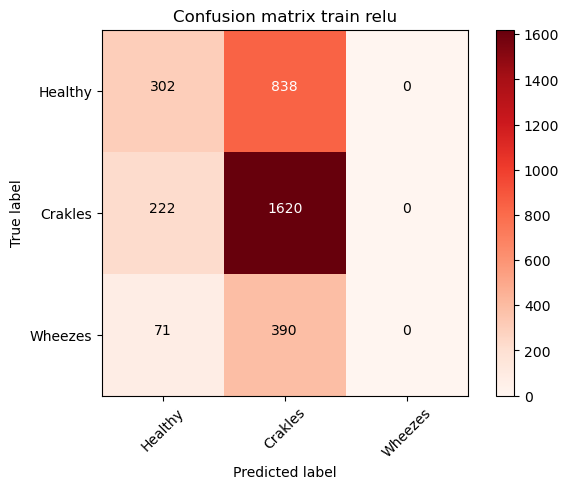

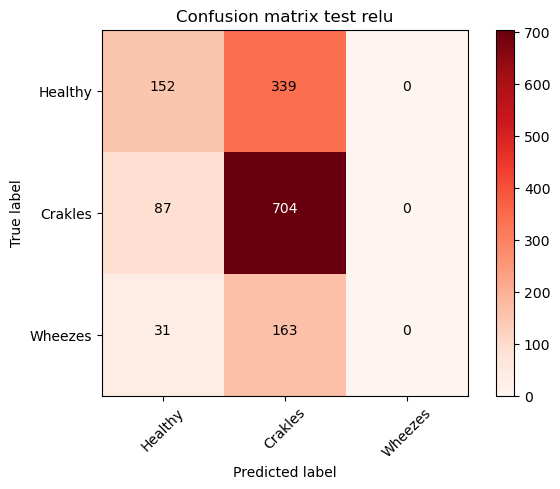

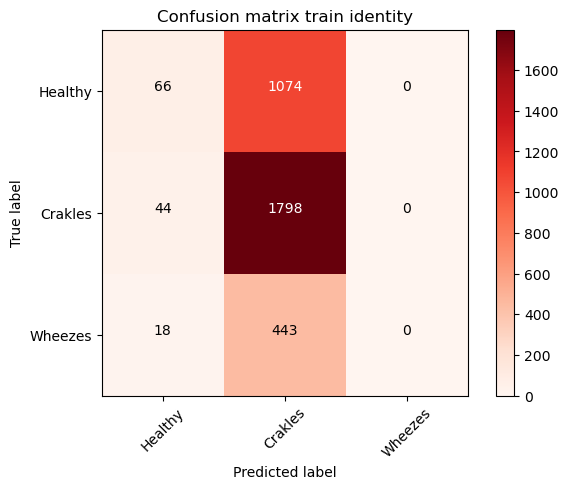

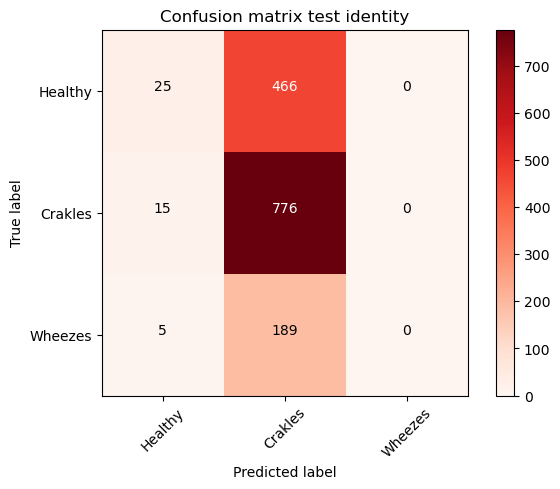

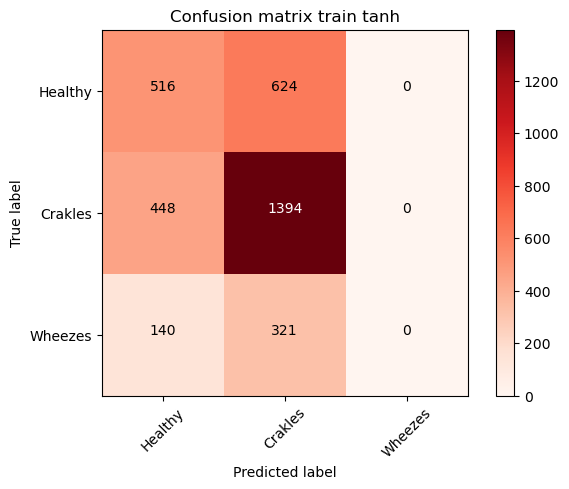

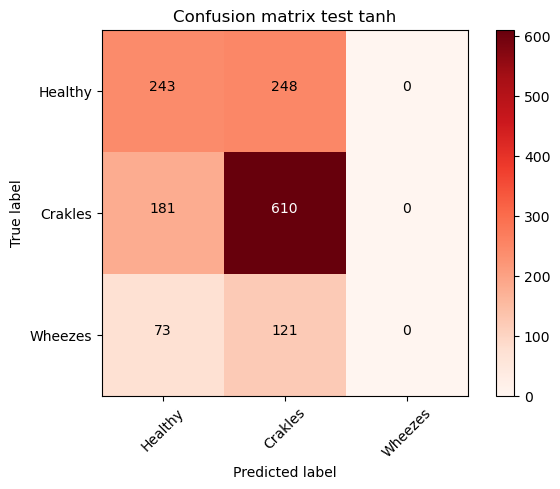

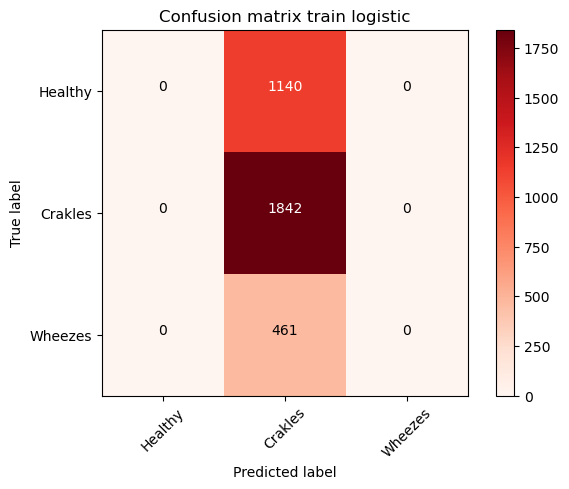

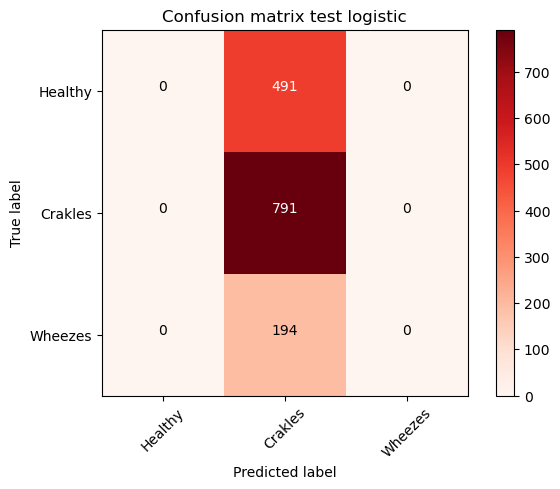

In [67]:
x=d2.drop(["Estado"],axis=1)
y=d2.Estado.values
test_size = 0.3
val_size  = test_size/(1-test_size) # Elementos de validación


print (x.shape, y.shape)
print ("test size %.2f"%test_size)
print ("val size is %.2f (relative to %.2f) "%(val_size, 1-test_size))

Xtv, Xts, ytv, yts = train_test_split(x, y, test_size=test_size)

print (Xtv.shape, Xts.shape)
mlp_relu = MLPClassifier(hidden_layer_sizes=(20,20,20), activation='relu', solver='adam', max_iter=10000) 
mlp_identity = MLPClassifier(hidden_layer_sizes=(20,20,20), activation='identity', solver='adam', max_iter=10000) 
mlp_tanh = MLPClassifier(hidden_layer_sizes=(20,20,20), activation='tanh', solver='adam', max_iter=10000)
mlp_logic=MLPClassifier(hidden_layer_sizes=(20,20,20), activation='logistic', solver='adam', max_iter=10000)
a=[mlp_relu,mlp_identity,mlp_tanh,mlp_logic]
me_da_pereza(a,Xtv,ytv,Xts,yts,["Healthy",'Crakles','Wheezes'])

## Dormir esta sobrevalorado 

Train  relu
------------
              precision    recall  f1-score   support

           0       0.52      0.16      0.24      1140
           1       0.56      0.94      0.70      1842
           2       1.00      0.00      0.00       461

    accuracy                           0.55      3443
   macro avg       0.69      0.36      0.31      3443
weighted avg       0.60      0.55      0.45      3443

Confusion matrix, without normalization
[[ 177  963    0]
 [ 118 1724    0]
 [  47  413    1]]
------------
Test  relu
              precision    recall  f1-score   support

           0       0.59      0.19      0.28       491
           1       0.56      0.94      0.70       791
           2       0.50      0.01      0.01       194

    accuracy                           0.56      1476
   macro avg       0.55      0.38      0.33      1476
weighted avg       0.56      0.56      0.47      1476

Confusion matrix, without normalization
[[ 91 400   0]
 [ 50 740   1]
 [ 13 180   1]]
MLPClass

c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


------------
Test  relu
              precision    recall  f1-score   support

           0       0.55      0.25      0.34       491
           1       0.57      0.90      0.70       791
           2       0.00      0.00      0.00       194

    accuracy                           0.57      1476
   macro avg       0.37      0.38      0.35      1476
weighted avg       0.49      0.57      0.49      1476

Confusion matrix, without normalization
[[121 370   0]
 [ 76 715   0]
 [ 25 169   0]]


c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MIGUEL\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


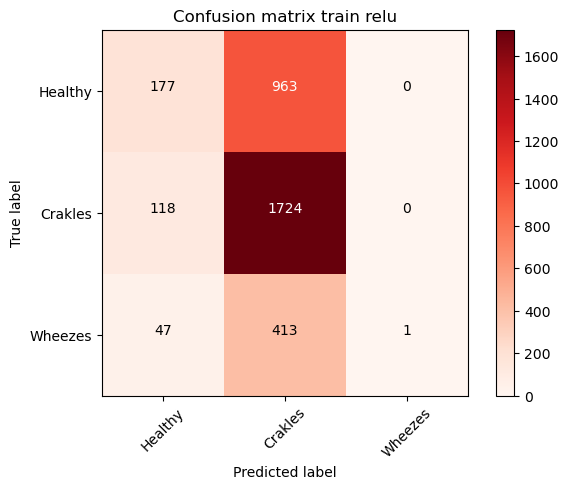

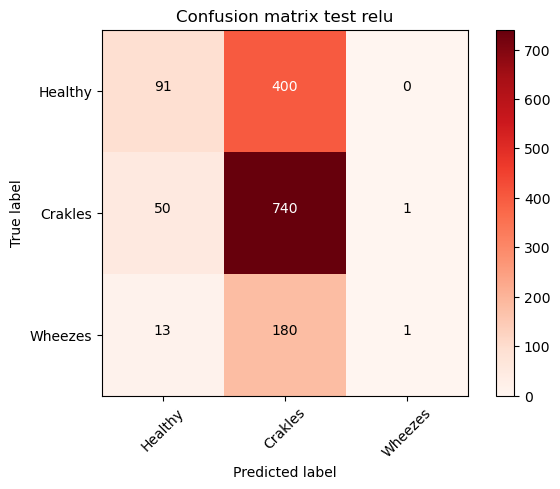

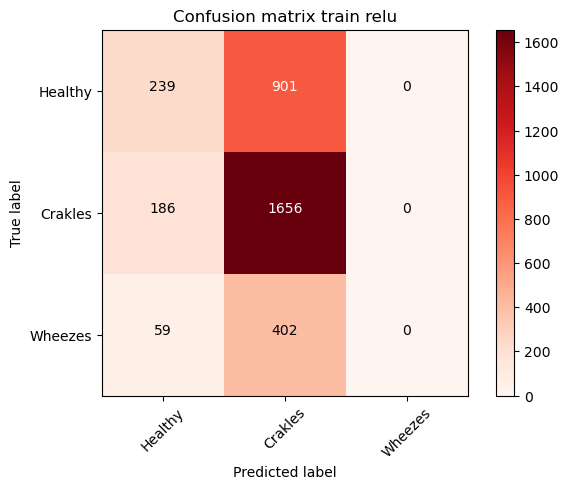

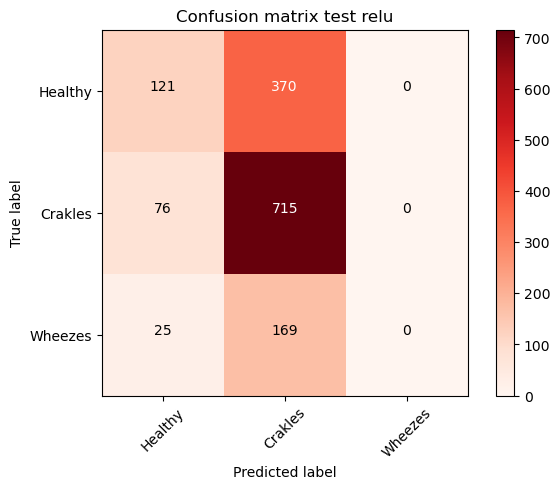

In [69]:
#Se busca el mejor sigmoide con los mejores macro parametros en este caso con la función de acurracy
best=optimizador(Xtv,ytv,Xts,yts,start=1,end=20)
metrics(best,Xtv,ytv,Xts,yts,["Healthy",'Crakles','Wheezes'])
print(best)
#Se busca una pequeña optimización con respecto a esos macroparametros, en este caso usando como puntuación la funcion f1
sem,_,_=best.hidden_layer_sizes
if sem>2:
    start=sem-2
    end=sem
else:
    start=sem
    end=sem+2
it=tuple_generator(start,end)
param_grid = {'hidden_layer_sizes': it}
grid_search = GridSearchCV(best, param_grid, cv=5,verbose=2,scoring="neg_log_loss") #En este caso cambiamos f1 ya que al ser multiples variables
grid_search.fit(Xtv, ytv)
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best Parameters:", best_params)
print("Best Score:", best_score)
#Se crea la mejor red neuronal posible con los parametros anteriores
the_bestest=MLPClassifier(hidden_layer_sizes=best_params["hidden_layer_sizes"], activation=best.activation, solver='adam', max_iter=10000) 
metrics(the_bestest,Xtv,ytv,Xts,yts,["Healthy",'Crakles','Wheezes'])